### In this notebook Bayessian approach to denoising images is preformed

Idea is taken from the [post](https://blog.statsbot.co/probabilistic-graphical-models-tutorial-d855ba0107d1)

# 1 Idea

The idea is the following: having $M \cdot N$ size image we assume that pixels values are observed variables of Markov process and corresponding $M \cdot N$ values of denoised image are hidden variables.

For simplicity we assume that image is binary, i.e. every pixel could be either -1, either 1.

We also assume that observed variable is connected only with corresponding hidden variable, but hidden variable is connected to its 4 neighbours. In this way we reflect the idea that pixel value should be close to the value of its neighbours.

If we denote hidden variables as $Y$ and observed variables as $X$, MAP estimation of $Y$ will be:

$$ \hat{Y} = \underset{Y}{\operatorname{argmax}}[P(Y|X)] = 
\underset{Y}{\operatorname{argmax}}[ log(P(Y|X) ]  = 
\underset{Y}{\operatorname{argmax}}[log(P(Y, X) - log(X) ] = 
\underset{Y}{\operatorname{argmax}}[log(P(X, Y))]$$

Then we model probability $P(X, Y)$ according to our model as:

$$ P(X, Y) = const \cdot \prod_{i, j} \Omega (X_{ij}, Y_{ij}) \prod_{(i,j), (k,l)} \Psi (Y_{ij}, Y_{kl}), $$
where $\Omega (X_{ij}, Y_{ij})$ reflects connection between hidden state and observed state. It should be bigger, when they are equal and lower, when the are different. Thus we can model it as:

$$ \Omega (X_{ij}, Y_{ij}) = \exp (w_1 \cdot X_{ij} Y_{ij} ) .$$

If $X_{ij}, Y_{ij}$ are the same, their product is 1, thus exponent is equal to $\exp(w_1)$. Otherwise, it is equal to $\exp(-w_1)$.

In the same manner we define $\Psi (Y_{ij}, Y_{kl})$ as:

$$ \Psi (Y_{ij}, Y_{kl}) = \exp(w_2 \cdot Y_{ij} Y_{kl}) .$$

Finally, our hidden state estimation will look like:

$$ \hat{Y} = \underset{Y}{\operatorname{argmax}} \left[
\sum_{i, j} w_1 X_{ij} Y_{ij} + \sum_{(i,j), (k,l)} w_2 Y_{i,j} Y_{k, l} \right]  $$

# 2 Data

As simple example we will use the following noisy image:

<img src="example/noisy.png">

# 3 Implementation

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [283]:
def loss(Y, X, w1, w2):
    m, n = X.shape
    return -func(Y, X, w1, w2)

def func(Y, X, w1=4, w2=5):
    # Y is augmented state
    m, n = X.shape
    central_Y = Y[1:m+1, 1:n+1]
    return w1 * np.sum(Y[1:m+1, 1:n+1]*X) + w2*np.sum(Y[0:m, 1:n+1]*central_Y +
                                                      Y[2:m+2, 1:n+1]*central_Y + 
                                                      Y[1:m+1, 0:n]*central_Y + 
                                                      Y[1:m+1, 2:n+2]*central_Y)

def func_grad(Y, X, m, n, w1=4, w2=5):
    # Y is augmented hidden state
    
    one_array = np.ones(shape=(m, n))
    return w1*X + w2*(Y[0:m, 1:n+1]*one_array + Y[2:m+2, 1:n+1]*one_array + 
                      Y[1:m+1, 0:n]*one_array + Y[1:m+1, 2:n+2]*one_array)

In [284]:
import copy

def to_grayscale(x):
    return 0.2989*x[:, :, 0] + 0.5870*x[:, :, 1] + 0.1140*x[:, :, 2] 

def to_norm_scale(channel):
    channel /= 2
    channel += 0.5
    channel *= 255
    return np.array(channel, dtype=np.int)

def denoise_image(noisy_image, mode='one_discrete', n_steps=300, 
                  batch_size=1000, start_lr=0.5, stop_lr=0.1, w1=4, w2=5):
 
    if mode == 'one_discrete':
        noisy_image //= noisy_image.max()
        noisy_image = np.array((noisy_image-0.5)*2, dtype=int)
    elif mode == 'one_continious':
        noisy_image = np.array(noisy_image, dtype=np.float)
        noisy_image /= noisy_image.max()
        noisy_image = np.array((noisy_image-0.5)*2, dtype=np.float)
    elif mode == 'rgb':
        r_noisy = copy.deepcopy(noisy_image[:, :, 0])
        g_noisy = copy.deepcopy(noisy_image[:, :, 1])
        b_noisy = copy.deepcopy(noisy_image[:, :, 2])
        
        r_recovered = denoise_image(r_noisy, mode='one_continious')[1]
        g_recovered = denoise_image(g_noisy, mode='one_continious')[1]
        b_recovered = denoise_image(b_noisy, mode='one_continious')[1]
        
        r_recovered = to_norm_scale(r_recovered)
        g_recovered = to_norm_scale(g_recovered)
        b_recovered = to_norm_scale(b_recovered)
        
        return noisy_image, np.dstack((r_recovered, g_recovered, b_recovered))
    else:
        raise AssertionError('choose mode: one_channel or rgb') 


    m, n = noisy_image.shape

    Y_curr = np.array(np.random.choice(a=[-1, 1], size=[m+2, n+2]), dtype=np.float) # augmented

    Y_curr[0, :] = np.zeros(n+2)
    Y_curr[m+1, :] = np.zeros(n+2)
    Y_curr[:, 0] = np.zeros(m+2)
    Y_curr[:, n+1] = np.zeros(m+2)

    n_steps = n_steps
    lr = np.linspace(start_lr, stop_lr, n_steps)
    losses = []
    batch_size = batch_size
    for step in tqdm(range(n_steps)):
        row_ixs = np.random.choice(range(m), size=batch_size)
        col_ixs = np.random.choice(range(n), size=batch_size)

        grad = func_grad(Y_curr, noisy_image, m, n, w1, w2)
        Y_curr[1:m+1, 1:n+1][row_ixs, col_ixs] += lr[step] * grad[row_ixs, col_ixs]
        
        if mode == 'one_discrete':
            Y_curr = np.sign(Y_curr)
        elif mode == 'one_continious':
            Y_curr[Y_curr<-1] = -1
            Y_curr[Y_curr>1] = 1
        else:
            print('smt wrong')
            return 0
        
        losses.append(loss(Y_curr, noisy_image, w1, w2))

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.set_title('Loss', fontsize=20)
    ax.plot(losses, c='g')
    ax.grid(True)
    
    return noisy_image, Y_curr[1:m+1, 1:n+1]

In [302]:
def plot_images(images_list, nrows, ncols, titles=None):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    fig.set_figheight(nrows*6)
    fig.set_figwidth(ncols*8)
    num_images = len(images_list)
    for ix in range(num_images):
        col_ix = ix//ncols
        row_ix = ix%ncols
        axes[col_ix, row_ix].imshow(images_list[ix], cmap='gray')
        if titles is not None:
            axes[col_ix, row_ix].set_title(titles[ix], fontsize=20)
        _ = axes[col_ix, row_ix].set_xticks([])
        _ = axes[col_ix, row_ix].set_yticks([])
    plt.tight_layout()

100%|██████████| 3000/3000 [00:11<00:00, 260.93it/s]


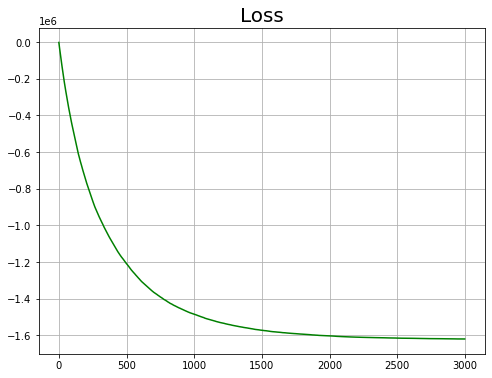

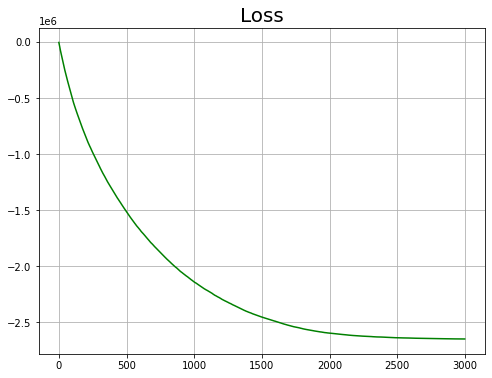

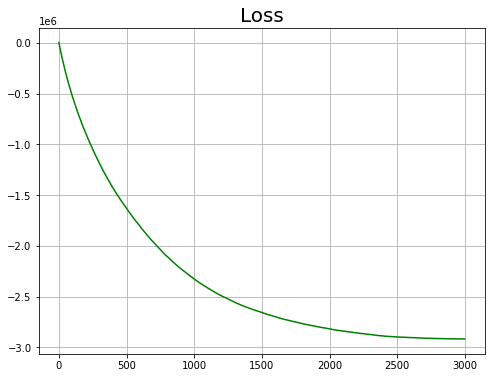

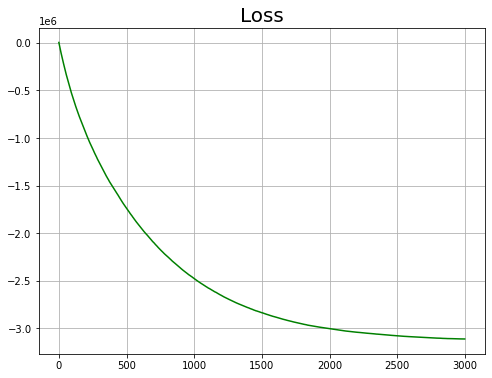

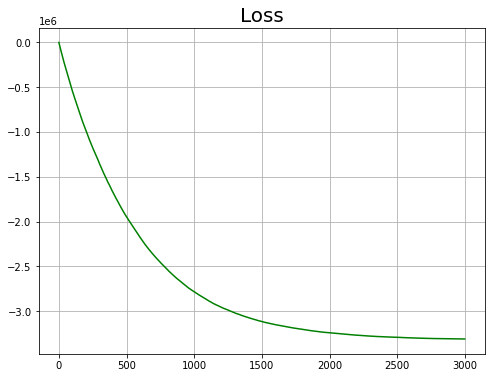

In [309]:
img_path = 'example/noisy.png'
img = np.array(Image.open(img_path))
recovered = []
w1_list = [1, 3, 5, 7, 9]
for w1 in w1_list:
    init_img, recov_img = denoise_image(noisy_image=to_grayscale(img), 
                                        mode='one_discrete', 
                                        n_steps=3000, batch_size=400, 
                                        start_lr=0.65, stop_lr=0.1, 
                                        w1=w1, w2=5)
    recovered.append(recov_img)

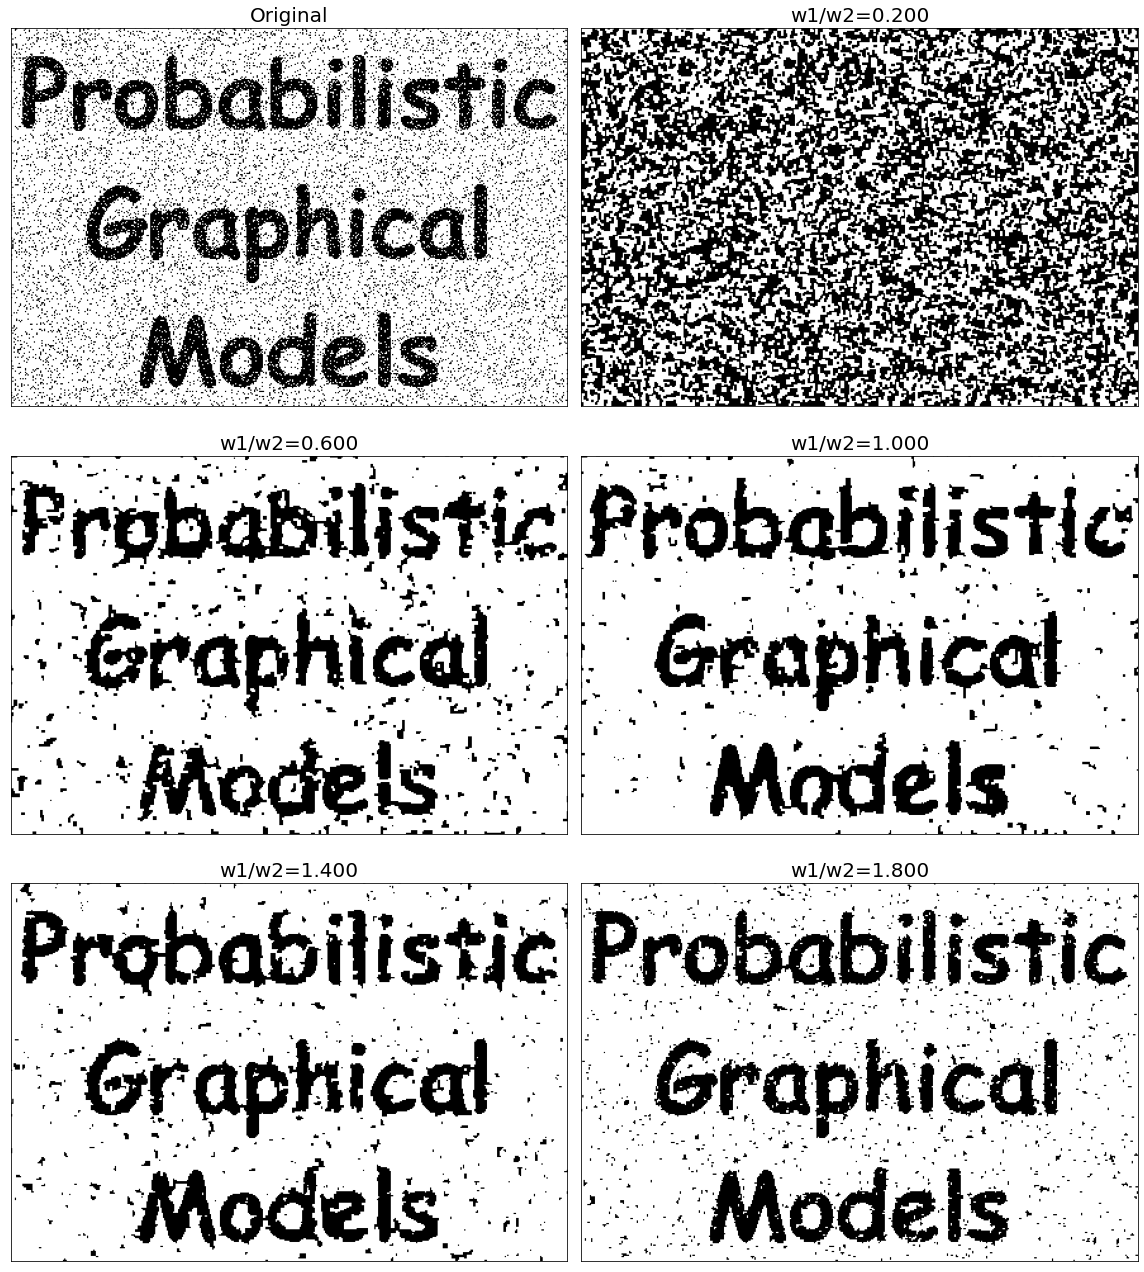

In [310]:
titles = ['Original'] + ['w1/w2={0:.3f}'.format(w1/5) for w1 in w1_list]
plot_images([init_img]+recovered, nrows=3, ncols=2, titles=titles)

In [251]:
difficult_img_path = 'example/difficult.png'
difficult_img = np.array(Image.open(difficult_img_path))

In [253]:
difficult_img.shape[0] * difficult_img.shape[1]

249841

100%|██████████| 4000/4000 [00:31<00:00, 125.51it/s]


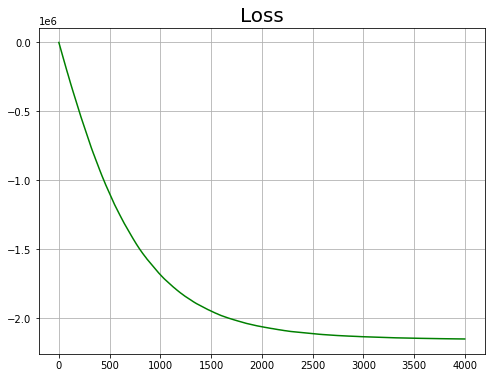

In [312]:
diff_input, recov_difficult = denoise_image(to_grayscale(difficult_img), mode='one_continious', 
                                            n_steps=4000, batch_size=500, 
                                            start_lr=0.4, stop_lr=0.1, 
                                            w1=10, w2=1 )

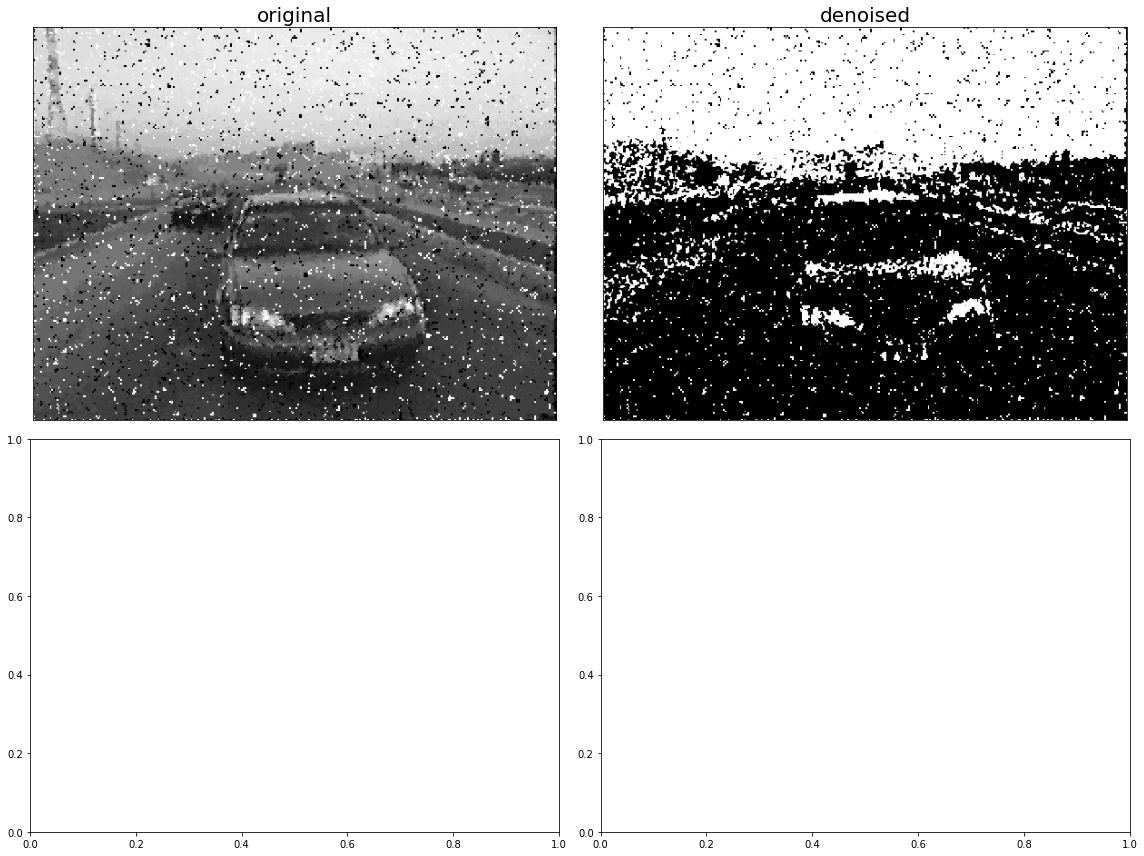

In [316]:
plot_images([diff_input, recov_difficult], nrows=2, ncols=2, titles=['original', 'denoised'])